# **Introduction**


In [1]:
import scipy.io #initializes libraries

import time
import math

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

In [2]:
mat = scipy.io.loadmat('Oxford_Battery_Degradation_Dataset_1.mat') #reads dataset

In [3]:
mat.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Cell1', 'Cell2', 'Cell3', 'Cell4', 'Cell5', 'Cell6', 'Cell7', 'Cell8'])

In [4]:
cycle_time_series=2442

In [5]:
input_data=[[],[],[],[]]

CELL_SIZE = [83, 78, 82, 52, 49, 51, 82, 82] # number of the cycles for each cell
counter=0
for i in range(0, 8): #breaks down dataset to return the values that we need
    cell_num = "Cell{}".format(i + 1)
    for j in range(0, CELL_SIZE[i]):
        curr=[]
        for u in range (0,cycle_time_series):
            cyc_num = "cyc{:04d}".format(j * 100) # if j=47, cyc_num = "cyc4700"; if j=1, cyc_num = "cyc0100"
            try:
                curr.append( mat[cell_num][0][cyc_num][0][0]["C1dc"][0][0]['T'][0][u][0])
            except ValueError:
                curr.append(float("NaN"))
        counter+=1
        input_data[0].append(counter)
        input_data[1].append(curr)
        input_data[2].append(j)
        input_data[3].append(i)
        

In [6]:
print(len(input_data[1])) 
#inputdata[0:cyclenofromall, 1:q values, 2:cyclenumberwithincell, 3:cellno][cyclenofromall]
input_data[3][170]

559


2

In [7]:
nan_count = np.isnan(input_data[1][:]).sum()
print(nan_count)

100122


In [8]:
#input_data[1][:]


### Replace NANs

In [9]:
average = np.nanmean(input_data[1][:])
print(average)
input_data[1][:] = np.nan_to_num(input_data[1][:], nan=average)


40.62510194133961


In [10]:
#input_data[1][:]

## Calculate RUL

In [11]:
# Define a function to calculate the remaining useful life (RUL)
def add_rul():
    RUL = []
    # Calculate the RUL as the difference between the maximum cycle value and the cycle value for each cell
    for i in range(len(input_data[1])):
        RUL.append(CELL_SIZE[input_data[3][i]] - input_data[2][i])
    return RUL

In [12]:
RUL=add_rul()
RUL[83]

78

In [13]:
#get shape of a list
def get_shape(lst):
    shape = []
    while isinstance(lst, list):
        shape.append(len(lst))
        lst = lst[0] if lst else None
    return shape

In [14]:
print("data shape: ", get_shape(input_data))
print("ruls shape: ", get_shape(RUL))

data shape:  [4, 559]
ruls shape:  [559]


The shape of input_data is (4, 559), which means we have 559 cycles from the 8 cells with 1500 time steps and charge q reading in mAh at each time step.
The shape of RUL is (559), which means we have the corresponding target RUL values for all the cell cycles.

Maximum value of y:  41.611675
Maximum value of all y:  42.901863
Minimum value of all y:  0.52003038
Minimum value of y:  40.188721
Mid-line:  40.900198
Mean-line:  40.6251019413396
Variance of values above mid-line:  0.0927424807241084


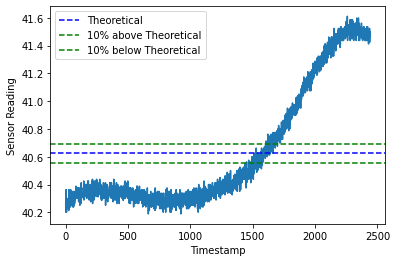

In [15]:
import copy
### Plot sample reading
# Extract x-axis and y-axis values
cycle=55
x = np.arange(0, cycle_time_series) # x-axis time series values from 0 to 2442
y = input_data[1][cycle]
#print(y)


#get all values of q

all_q_values=copy.deepcopy(input_data[1][:])
#print(all_q_values)
# Calculate mean value of all values of q
# mean_y = np.mean(all_q_values)

# Compute the mean of values above 10
# array = np.array(all_q_values)
# mask = array > 10
# mean_y = np.mean(array[mask])

mean_y = np.mean(all_q_values)

# Calculate max and min values of y
y_max = np.max(y)
y_min = np.min(y)

# Calculate max and min values of all y
y_all_max = np.max(all_q_values)
y_all_min = np.min(all_q_values)

#print(y_all_max)


# Calculate mid-line
mid_line = (y_max + y_min) / 2

print("Maximum value of y: ", y_max)
print("Maximum value of all y: ", y_all_max)
print("Minimum value of all y: ", y_all_min)


print("Minimum value of y: ", y_min)
print("Mid-line: ", mid_line)
print("Mean-line: ", mean_y)

# Calculate y-coordinates for lines 10% between mean_y and y_max/y_min
y_25_above = mean_y + (0.03 * (y_all_max - mean_y))
y_25_below = mean_y - (0.03 * (y_all_max - mean_y))

# y_25_above =41
# y_25_below=39

# Calculate variance of values above mid_line
above_midline = y > mean_y
y_above_midline = y[above_midline]
variance_above_midline = np.var(y_above_midline)

print("Variance of values above mid-line: ", variance_above_midline)

# Plot the data
plt.plot(x, y) # Plot the data points
plt.axhline(mean_y, color='b', linestyle='--', label='Theoretical') # Add the mean_y to the plot
plt.axhline(y_25_above, color='g', linestyle='--', label='10% above Theoretical') # Add line 25% above Mid-line
plt.axhline(y_25_below, color='g', linestyle='--', label='10% below Theoretical') # Add line 25% below Mid-line
plt.xlabel('Timestamp') # Add x-axis label
plt.ylabel('Sensor Reading') # Add y-axis label
#plt.title('Plot of sensor data with Theoretical and 25% lines') # Add plot title
plt.legend() # Add legend
plt.show() # Show the plot


# Margin-Aware Pruning

In [16]:
def margin_prune (sample, theoritical, above, below):
    #fig = plt.figure(figsize=(6, 4))
    
    # clip the curves to positive values only
    sample_curve = np.clip(sample, theoritical, np.inf)
    theoritical_curve = np.clip(theoritical, theoritical, np.inf)
    
    # plot the data
    #plt.plot(theoritical_curve)
    
    # fill between the curves
    #plt.fill_between(range(len(sample)), sample, theoritical, where=(sample > theoritical), interpolate=True, color='green', alpha=0.7)

    # calculate the area
    area = np.trapz(sample_curve - theoritical_curve, dx=1)
    
    #plt.title('Positive area between two curves: ' + str(area)  )
    
    # Plot the data
#     plt.plot(sample, color='r') # Plot the data points
#     plt.axhline(theoritical, color='b', linestyle='--', label='Theoretical') # Add the mean_y to the plot
#     plt.axhline(above, color='g', linestyle='-.', label='Margin Above') # Add line 25% above Mid-line
#     plt.axhline(below, color='g', linestyle='-.', label='Margin Below') # Add line 25% below Mid-line
#     plt.xlabel('Timestamp',fontsize=14) # Add x-axis label
#     plt.ylabel('Sensor Reading',fontsize=14) # Add y-axis label
    
    
    # calculate the area between theoritical and above
    theoritical_array = np.full((len(sample_curve),), theoritical)
    above_array = np.full((len(sample_curve),), above)

    abovearea = np.trapz(above_array - theoritical_array, dx=1)
    #print(abovearea)
#     plt.fill_between(range(len(theoritical_array)), above_array, theoritical_array, where=(above_array > theoritical_array), interpolate=True, color='pink', alpha=0.5)

#     fig = plt.gcf()
#     fig.set_facecolor('white')
#     plt.gca().set_facecolor('white')

#     # Add a border around the plot
#     for spine in plt.gca().spines.values():
#         spine.set_edgecolor('black')
#         spine.set_linewidth(1)

#     plt.savefig('sample3.png', dpi=300, bbox_inches='tight')
    
#     plt.show()
    
    failure=True
    if(abovearea<=area):
        failure=True
    else:
        failure=False
        
    #return bool fail or not 
    return(failure)


In [17]:
margin_prune (input_data[1][cycle], mean_y, y_25_above, y_25_below)

True

In [18]:
cycles=559

# Amplitude-based Hueristic

In [19]:
def get_amplitude(upper_curve,lower_curve):
    
    temp_mean = np.mean(upper_curve)
    lower_curve=temp_mean
    
    # Calculate the difference between the two curves
    diff = upper_curve - lower_curve
    #print(diff)
    #print(len(diff))

    # Identify the positive areas
    positive_areas = np.where(diff > 0)[0]
    #print(positive_areas)
    #print(len(positive_areas))

    # Find the maximum value in each positive area
    max_values = []
    for i in range(len(positive_areas)-1):
        start = positive_areas[i]
        end = positive_areas[i+1]
        if diff[start:end].size > 0:
            max_values.append(np.max(diff[start:end]))

    # Calculate the average of the maximum values
    if len(max_values)>0:
        average_amplitude = np.mean(max_values)
    else:
        average_amplitude=0
    
    #print(average_amplitude)
    
    return(average_amplitude)


In [20]:
def get_length (upper_curve,lower_curve):
    
    # Calculate the difference between the two curves
    diff = upper_curve - lower_curve

    # Find indices of positive areas
    positive_indices = np.where(diff > 0)[0]

    # Compute length of positive areas
    positive_lengths = len(positive_indices)

    #print("Length of positive areas:", positive_lengths)
    return (positive_lengths)

In [21]:
def hueristic (sample, theoritical, above, below, cycle):
    ##amplitude
    amplitude=get_amplitude(sample,theoritical)
    #print(amplitude)
    
    temp_mean = np.mean(sample)
    #normalized_amplitude = (amplitude - 0) / ((y_all_max-mean_y) - 0)
    normalized_amplitude = (amplitude - 0) / ((y_all_max-temp_mean) - 0)

    #print(normalized_amplitude)
    #print(y_all_max)

    ##length
    length=get_length (sample,theoritical)
    #print(length)
    normalized_length=length/cycle_time_series
    #print(normalized_length)
    
    ##variance
    # Compute the minimum and maximum variance values in the dataset and get current variance
#     variance_list=[]
#     for i in range(cycles):
#         temp = np.sum((input_data[1][i] - mean_y)**2) / (len(sample) - 1)
#         variance_list.append(temp)

    
    # Current variance    
    variance_list = np.var(input_data[1][:], axis=1)
    variance=variance_list[cycle]
    #print(variance)
    # Compute the minimum and maximum variance values in the dataset
    min_variance = np.min(variance_list)
    max_variance = np.max(variance_list)
    #print(min_variance,max_variance)

    # Normalize the variance value between 0 and 1
    normalized_variance = ((variance - min_variance) / (max_variance - min_variance))

    #print(normalized_variance)

    DLS=(normalized_amplitude+normalized_length+normalized_variance)/3
    
    return DLS 
    

In [22]:
hueristic (input_data[1][cycle], mean_y, y_25_above, y_25_below, cycle)

0.3236461227268889

## Evaluate the heuristic module using RUL

In [23]:
## create solutions arrays
import copy
import timeit
import time


RUL_list=copy.deepcopy(RUL)
Heuristic_list=[]
no_pruning=[]
margin_15=[]
margin_20=[]
margin_30=[]
amplitude_only=[]
variance_only=[]
length_only=[]
amplitude_variance=[]
amplitude_length=[]
variance_length=[]

pruning_percent1=0.05
pruning_percent2=0.10
pruning_percent3=0.15
pruning_percent4=0.20



#normalize RUL
minimum = min(RUL_list)
maximum = max(RUL_list)
normalized_RUL = [(x - minimum) / (maximum - minimum) for x in RUL_list]
    
#Heuristic_list
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        DLS=hueristic (input_data[1][i], mean_y, above, below,i)
    else:
        DLS=0
    execution_time=time.time() - start_time
    Heuristic_list.append([DLS,execution_time])

#no_pruning
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    #is_failure=margin_prune (processed_train_data[i][:, 2], mean_y, above, below)
    DLS=hueristic (input_data[1][i], mean_y, above, below,i)
    execution_time=time.time() - start_time
    no_pruning.append([DLS,execution_time])
    
#margin_15
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent2 * (y_all_max - mean_y)
    below = mean_y - pruning_percent2 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        DLS=hueristic (input_data[1][i], mean_y, above, below,i)
    else:
        DLS=0
    execution_time=time.time() - start_time
    margin_15.append([DLS,execution_time])
        
#margin_20
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent3 * (y_all_max - mean_y)
    below = mean_y - pruning_percent3 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        DLS=hueristic (input_data[1][i], mean_y, above, below,i)
    else:
        DLS=0
    execution_time=time.time() - start_time
    margin_20.append([DLS,execution_time])
    
#margin_30
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent4 * (y_all_max - mean_y)
    below = mean_y - pruning_percent4 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        DLS=hueristic (input_data[1][i], mean_y, above, below,i)
    else:
        DLS=0
    execution_time=time.time() - start_time
    margin_30.append([DLS,execution_time])

#amplitude_only
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        amplitude=get_amplitude(input_data[1][i],mean_y)
        temp_mean = np.mean(input_data[1][i])
        normalized_amplitude = (amplitude - 0) / ((y_all_max-temp_mean) - 0)
        DLS=normalized_amplitude
    else:
        DLS=0
    execution_time=time.time() - start_time
    amplitude_only.append([DLS,execution_time])
    
#variance_only
# variance_list=[]
# for i in range(cycles):
#     temp = np.sum((input_data[1][i] - mean_y)**2) / (len(input_data[1][0]) - 1)
#     variance_list.append(temp)
variance_list = np.var(input_data[1][:], axis=1)
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        variance=variance_list[i]
        min_variance = np.min(variance_list)
        max_variance = np.max(variance_list)
        normalized_variance = ((variance - min_variance) / (max_variance - min_variance))
        DLS=normalized_variance
    else:
        DLS=0
    execution_time=time.time() - start_time
    variance_only.append([0+DLS,execution_time])
    
#length_only
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        length=get_length (input_data[1][i],mean_y)
        normalized_length=length/cycle_time_series
        DLS=normalized_length
    else:
        DLS=0
    execution_time=time.time() - start_time
    length_only.append([DLS,execution_time])
    
#amplitude_variance
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        amplitude=get_amplitude(input_data[1][i],mean_y)
        temp_mean = np.mean(input_data[1][i])
        normalized_amplitude = (amplitude - 0) / ((y_all_max-temp_mean) - 0)
        variance = variance_list[i]
        min_variance = np.min(variance_list)
        max_variance = np.max(variance_list)
        normalized_variance = ((variance - min_variance) / (max_variance - min_variance))
        DLS=(normalized_amplitude+normalized_variance)/2
    else:
        DLS=0
    #print(DLS)
    execution_time=time.time() - start_time
    amplitude_variance.append([DLS,execution_time])
    
#amplitude_length
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        amplitude=get_amplitude(input_data[1][i],mean_y)
        temp_mean = np.mean(input_data[1][i])
        normalized_amplitude = (amplitude - 0) / ((y_all_max-temp_mean) - 0)
        length=get_length (input_data[1][i],mean_y)
        normalized_length=length/cycle_time_series
        DLS=(normalized_amplitude+normalized_length)/2
    else:
        DLS=0
    execution_time=time.time() - start_time
    amplitude_length.append([DLS,execution_time])
    
#variance_length
for i in range(cycles):
    start_time = time.time()
    above = mean_y + pruning_percent1 * (y_all_max - mean_y)
    below = mean_y - pruning_percent1 * (y_all_max - mean_y)
    is_failure=margin_prune (input_data[1][i], mean_y, above, below)
    DLS=0
    if is_failure:
        length=get_length (input_data[1][i],mean_y)
        normalized_length=length/cycle_time_series
        variance = variance_list[i]
        min_variance = np.min(variance_list)
        max_variance = np.max(variance_list)
        normalized_variance = ((variance - min_variance) / (max_variance - min_variance))
        DLS=(normalized_length+normalized_variance)/2
    else:
        DLS=0
    execution_time=time.time() - start_time
    variance_length.append([DLS,execution_time])

In [24]:
# Calculate correlation coefficients
normalized_flipped_RUL1 = [1 - x for x in normalized_RUL]

#Heuristic_list
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in Heuristic_list], np.isnan([row[0] for row in Heuristic_list]))
# Compute the normalized cross-correlation
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
print('Heuristic_list',ncc)

#no_pruning
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in no_pruning], np.isnan([row[0] for row in no_pruning]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('no_pruning',ncc)

#margin_15
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in margin_15], np.isnan([row[0] for row in margin_15]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('margin_15',ncc)

#margin_20
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in margin_20], np.isnan([row[0] for row in margin_20]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('margin_20',ncc)

#margin_30
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in margin_30], np.isnan([row[0] for row in margin_30]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('margin_30',ncc)

#amplitude_only
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in amplitude_only], np.isnan([row[0] for row in amplitude_only]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('amplitude_only',ncc)

#variance_only
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in variance_only], np.isnan([row[0] for row in variance_only]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('variance_only',ncc)

#length_only
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in length_only], np.isnan([row[0] for row in length_only]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('length_only',ncc)

#amplitude_variance
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in amplitude_variance], np.isnan([row[0] for row in amplitude_variance]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('amplitude_variance',ncc)

#amplitude_length
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in amplitude_length], np.isnan([row[0] for row in amplitude_length]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('amplitude_length',ncc)

#variance_length
# Create masked arrays
masked_list1 = np.ma.masked_array(normalized_flipped_RUL1[:cycles], np.isnan(normalized_flipped_RUL1[:cycles]))
masked_list2 = np.ma.masked_array([row[0] for row in variance_length], np.isnan([row[0] for row in variance_length]))
# Calculate correlation coefficient
#corr_coef = np.ma.corrcoef(masked_list1, masked_list2)[0,1]
corr = np.correlate(masked_list1, masked_list2, mode='valid') / (np.linalg.norm(masked_list1) * np.linalg.norm(masked_list2))
ncc = np.mean(corr)
print('variance_length',ncc)


Heuristic_list 0.7994478165052218
no_pruning 0.8911513127511306
margin_15 0.6026137623019359
margin_20 0.5547186726651925
margin_30 0.5334005597384534
amplitude_only 0.8187720538366169
variance_only 0.8229413967199746
length_only 0.7191600150612836
amplitude_variance 0.8288311326689152
amplitude_length 0.7595150239105944
variance_length 0.7920755994022028


/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

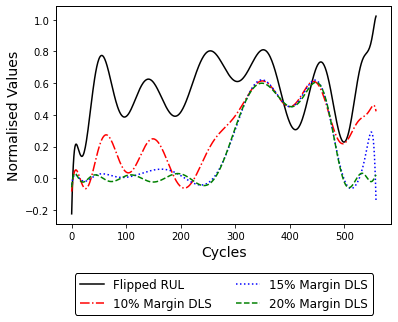

In [25]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4))


# Example data
#print(Heuristic_list)
Heuristic_list1 = [row[0] for row in Heuristic_list]
normalized_RUL1 = copy.deepcopy(normalized_RUL[:cycles])
normalized_flipped_RUL1 = [1 - x for x in normalized_RUL1]
margin_151 = [row[0] for row in margin_15]
margin_201 = [row[0] for row in margin_20]


# Create x-axis values
x_values = np.arange(len(normalized_RUL1))

# Calculate coefficients for best fit lines
Heuristic_coeffs = np.polyfit(x_values, Heuristic_list1, 20)
normalized_RUL_coeffs = np.polyfit(x_values, normalized_RUL1, 20)
normalized_flippedRUL_coeffs = np.polyfit(x_values, normalized_flipped_RUL1, 20)
margin15_coeffs = np.polyfit(x_values, margin_151, 20)
margin20_coeffs = np.polyfit(x_values, margin_201, 20)


# Create best fit line functions
Heuristic_fit = np.poly1d(Heuristic_coeffs)
normalized_RUL_fit = np.poly1d(normalized_RUL_coeffs)
normalized_flippedRUL_fit = np.poly1d(normalized_flippedRUL_coeffs)
margin15_fit = np.poly1d(margin15_coeffs)
margin20_fit = np.poly1d(margin20_coeffs)


# Create plot
fig, ax = plt.subplots()
#ax.plot(x_values, Heuristic_list1, label='Heuristic List', marker='o')
#ax.plot(x_values, normalized_RUL1, label='Normalized RUL', marker='s')
#ax.plot(x_values, normalized_RUL_fit(x_values), 'k-', label='RUL Best Fit')

ax.plot(x_values, normalized_flippedRUL_fit(x_values), 'k-', label='Flipped RUL')
ax.plot(x_values, Heuristic_fit(x_values), 'r-.', label='10% Margin DLS')
ax.plot(x_values, margin15_fit(x_values), 'b:', label='15% Margin DLS')
ax.plot(x_values, margin20_fit(x_values), 'g--', label='20% Margin DLS')


# Set axis labels, title, and legend
ax.set_xlabel('Cycles',fontsize=14)
ax.set_ylabel('Normalised Values',fontsize=14)

#ax.set_title('Normalized RUL and Heuristics vs Cycles')
ax.legend(fontsize=12, frameon=True, framealpha=1, edgecolor='black', facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=2)

ax.set_facecolor("white")

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.savefig('Margins.png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()


/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

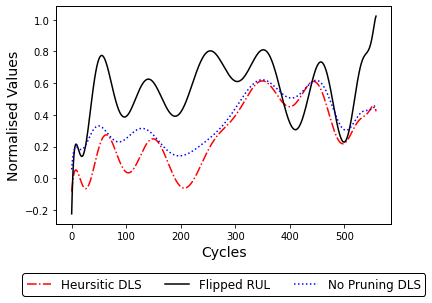

In [26]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4))

# Example data
#print(Heuristic_list)
Heuristic_list1 = [row[0] for row in Heuristic_list]
normalized_RUL1 = copy.deepcopy(normalized_RUL[:cycles])
normalized_flipped_RUL1 = [1 - x for x in normalized_RUL1]
no_pruning1 = [row[0] for row in no_pruning]
# Replace NaN values with zeros
no_pruning1 = np.nan_to_num(no_pruning1)


# Create x-axis values
x_values = np.arange(len(normalized_RUL1))

# Calculate coefficients for best fit lines
Heuristic_coeffs = np.polyfit(x_values, Heuristic_list1, 20)
normalized_RUL_coeffs = np.polyfit(x_values, normalized_RUL1, 20)
normalized_flippedRUL_coeffs = np.polyfit(x_values, normalized_flipped_RUL1, 20)
no_pruning_coeffs = np.polyfit(x_values, no_pruning1, 20)


# Create best fit line functions
Heuristic_fit = np.poly1d(Heuristic_coeffs)
normalized_RUL_fit = np.poly1d(normalized_RUL_coeffs)
normalized_flippedRUL_fit = np.poly1d(normalized_flippedRUL_coeffs)
no_pruning_fit = np.poly1d(no_pruning_coeffs)


# Create plot
fig, ax = plt.subplots()
#ax.plot(x_values, Heuristic_list1, label='Heuristic List', marker='o')
#ax.plot(x_values, normalized_RUL1, label='Normalized RUL', marker='s')
ax.plot(x_values, Heuristic_fit(x_values), 'r-.', label='Heursitic DLS')
#ax.plot(x_values, normalized_RUL_fit(x_values), 'k-', label='RUL Best Fit')
ax.plot(x_values, normalized_flippedRUL_fit(x_values), 'k-', label='Flipped RUL')
ax.plot(x_values, no_pruning_fit(x_values), 'b:', label='No Pruning DLS')


# Set axis labels, title, and legend
ax.set_xlabel('Cycles',fontsize=14)
ax.set_ylabel('Normalised Values',fontsize=14)

#ax.set_title('Normalized RUL and Heuristics vs Cycles')
ax.legend(fontsize=12, frameon=True, framealpha=1, edgecolor='black', facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

ax.set_facecolor("white")

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.savefig('pruning.png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()


/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

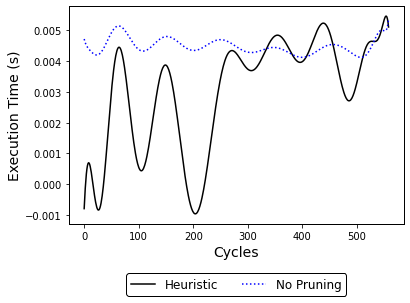

In [27]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4))

# Example data
#print(Heuristic_list)
Heuristic_list1 = [row[1] for row in Heuristic_list]
normalized_RUL1 = copy.deepcopy(normalized_RUL[:cycles])
no_pruning1 = [row[1] for row in no_pruning]
# Replace NaN values with zeros
no_pruning1 = np.nan_to_num(no_pruning1)


# Create x-axis values
x_values = np.arange(len(normalized_RUL1))

# Calculate coefficients for best fit lines
Heuristic_coeffs = np.polyfit(x_values, Heuristic_list1, 20)
no_pruning_coeffs = np.polyfit(x_values, no_pruning1, 20)


# Create best fit line functions
Heuristic_fit = np.poly1d(Heuristic_coeffs)
no_pruning_fit = np.poly1d(no_pruning_coeffs)


# Create plot
fig, ax = plt.subplots()

ax.plot(x_values, Heuristic_fit(x_values), 'k-', label='Heuristic')
ax.plot(x_values, no_pruning_fit(x_values), 'b:', label='No Pruning')


# Set axis labels, title, and legend
ax.set_xlabel('Cycles',fontsize=14)
ax.set_ylabel('Execution Time (s)',fontsize=14)

#ax.set_title('Normalized RUL and Heuristics vs Cycles')
ax.legend(fontsize=12, frameon=True, framealpha=1, edgecolor='black', facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

ax.set_facecolor("white")

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.savefig('execution.png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()


/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)
/Users/balsamalkouz/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


<Figure size 432x288 with 0 Axes>

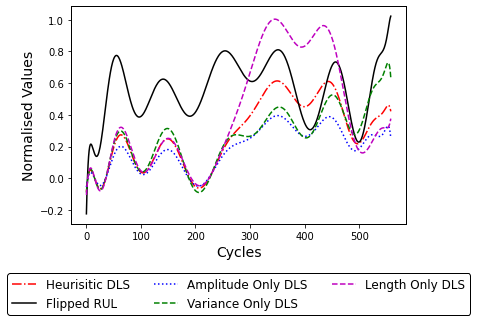

In [28]:
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(6, 4))

# Heuristic_list=[]
# no_pruning=[]
# margin_15=[]
# margin_20=[]
# amplitude_only=[]
# variance_only=[]
# length_only=[]
# amplitude_variance=[]
# amplitude_length=[]
# variance_length=[]

# Example data
#print(Heuristic_list)
Heuristic_list1 = [row[0] for row in Heuristic_list]
normalized_RUL1 = copy.deepcopy(normalized_RUL[:cycles])
normalized_flipped_RUL1 = [1 - x for x in normalized_RUL1]
amplitude_only1 = [row[0] for row in amplitude_only]
variance_only1 = [row[0] for row in variance_only]
length_only1 = [row[0] for row in length_only]


# Replace NaN values with zeros
#no_pruning1 = np.nan_to_num(no_pruning1)


# Create x-axis values
x_values = np.arange(len(normalized_RUL1))

# Calculate coefficients for best fit lines
Heuristic_coeffs = np.polyfit(x_values, Heuristic_list1, 20)
normalized_RUL_coeffs = np.polyfit(x_values, normalized_RUL1, 20)
normalized_flippedRUL_coeffs = np.polyfit(x_values, normalized_flipped_RUL1, 20)
amplitude_only_coeffs = np.polyfit(x_values, amplitude_only1, 20)
variance_only_coeffs = np.polyfit(x_values, variance_only1, 20)
length_only_coeffs = np.polyfit(x_values, length_only1, 20)


# Create best fit line functions
Heuristic_fit = np.poly1d(Heuristic_coeffs)
normalized_RUL_fit = np.poly1d(normalized_RUL_coeffs)
normalized_flippedRUL_fit = np.poly1d(normalized_flippedRUL_coeffs)
amplitude_only_fit = np.poly1d(amplitude_only_coeffs)
variance_only_fit = np.poly1d(variance_only_coeffs)
length_only_fit = np.poly1d(length_only_coeffs)


# Create plot
fig, ax = plt.subplots()

ax.plot(x_values, Heuristic_fit(x_values), 'r-.', label='Heurisitic DLS')
ax.plot(x_values, normalized_flippedRUL_fit(x_values), 'k-', label='Flipped RUL')
ax.plot(x_values, amplitude_only_fit(x_values), 'b:', label='Amplitude Only DLS')
ax.plot(x_values, variance_only_fit(x_values), 'g--', label='Variance Only DLS')
ax.plot(x_values, length_only_fit(x_values), 'm--', label='Length Only DLS')


# Set axis labels, title, and legend
ax.set_xlabel('Cycles',fontsize=14)
ax.set_ylabel('Normalised Values',fontsize=14)

#ax.set_title('Normalized RUL and Heuristics vs Cycles')
ax.legend(fontsize=12, frameon=True, framealpha=1, edgecolor='black', facecolor='white', loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=3)

ax.set_facecolor("white")

# Add a border around the plot
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1)

plt.savefig('singlemethod.png', dpi=300, bbox_inches='tight')

# Display plot
plt.show()
